In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os.path
import glob
import pandas as pd
import pretty_midi
import csv

In [3]:
pkl_dir = './'

### Measure error rate (single pair)

In [4]:
def getSheetRefLocs(scoreid, striplens, changeDPI = False):
    
    # get annotation file
    annot_dir = 'annot_data'
    piece = scoreid.split('_')
    annot_file_beats = '%s/%s_%s_beats.csv' % (annot_dir, piece[0], piece[1])
    df_all = pd.read_csv(annot_file_beats)
    
    # calculate global pixel position
    scoreid = piece[1]+'_'+piece[2]
    df = df_all.loc[df_all.score == scoreid]
    pixelOffset = np.cumsum([0] + striplens)  # cumulative pixel offset for each strip
    stripsPerPage = [df.loc[df.page == i,'strip'].max() for i in range(df.page.max()+1) ]
    stripOffset = np.cumsum([0] + stripsPerPage)
    stripIdx = stripOffset[df.page] + df.strip - 1  # cumulative strip index
    if changeDPI:
        hpixlocs = pixelOffset[stripIdx] + (df.hpixel  * 100 // 72)
    else:
        hpixlocs = pixelOffset[stripIdx] + df.hpixel

    return hpixlocs.values

In [5]:
def getMidiRefLocs(midiID, scoreID, fs, zeroPad, timeMapping):
    
    annot_file = 'annot_data/midi/' + midiID + '.csv'
    timeStamps = []
    with open(annot_file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            if row[0] != '-':
                timeStamps.append(float(row[0]))
            else:
                timeStamps.append(float('inf'))
    timeStamps = np.array(timeStamps)
    
    # convert to mapped frames
    frames = (timeStamps - timeStamps[0]) * fs
    mapped_frms = [i for i, elem in enumerate(timeMapping) if elem != -1]
    orig_frms = [elem for elem in timeMapping if elem != -1]
    orig_frms = np.array(orig_frms) - orig_frms[0]
    mapped_interp = np.interp(frames, orig_frms, mapped_frms)
    padded = mapped_interp + zeroPad
    
    return padded

In [6]:
def calcPredErrors(hyp_file, predType, changeDPI = False, verbose=False):
    
    # load hypothesis data
    print(hyp_file)
    dhyp = pickle.load(open(hyp_file, 'rb'))
    fs = dhyp['fs']
    zeroPad = dhyp['zeroPad']
    timeMapping = dhyp['timeMapping']
    striplens = dhyp['striplens']
    wp = dhyp['wp']
    
    striplens = [s/3 for s in striplens]
    
    # get ground truth annotations
    scoreID = os.path.splitext(os.path.basename(hyp_file))[0] # e.g. chopin_op68no3_v1.pkl
    midiID = scoreID.split('_')[0] + '_' + scoreID.split('_')[1] # chopin_op68no3
    sheet_ref_beats = getSheetRefLocs(scoreID, striplens, changeDPI)
    midi_ref_beats = getMidiRefLocs(midiID, scoreID, fs, zeroPad, timeMapping)

    # get beat predictions
    if predType == 'wp':
        sheet_preds = wp[:,0]
        midi_preds = wp[:,1]
    elif predType == 'globallinear':
        sheet_preds = wp[[0,-1],0]
        midi_preds = wp[[0,-1],1]
    else:
        print('Unrecognized prediction type: %s' % predType)
        sys.exit(1)
        
    # calculate prediction errors
    hypFrames = np.interp(sheet_ref_beats, sheet_preds, midi_preds)
    hypPixels = np.interp(midi_ref_beats, midi_preds, sheet_preds)
    minLen = np.min((len(hypFrames), len(hypPixels)))
    errsFrames = hypFrames[0:minLen] - midi_ref_beats[0:minLen]
    errsTime = errsFrames * 1000.0 / fs  # in ms
    errsPixels = hypPixels[0:minLen] - sheet_ref_beats[0:minLen]    
    
    if verbose:
        for i in range(minLen):
            print(hypFrames[i], midi_ref_beats[i])
        print('---------------------')
        for i in range(minLen):
            print(hypPixels[i], sheet_ref_beats[i])
        
    return errsTime, errsPixels, midi_ref_beats, sheet_ref_beats

In [7]:
def calcErrorStats(errs_raw, tols, isSingle = False):
    if isSingle:
        errs = errs_raw
    else:
        errs = np.array([err for sublist in errs_raw for err in sublist])
    errs = errs[~np.isnan(errs)] # when beat is not annotated, value is nan
    errorRates = []
    for tol in tols:
        toAdd = np.sum(np.abs(errs) > tol) * 1.0 / len(errs)
        errorRates.append(toAdd)
    return errorRates

In [8]:
def calcErrorStats_globalLinear(errs_raw, tols):
    
    # accumulate only the non-downbeat predictions
    errs = []
    for sublist in errs_raw:
        sum1 = np.nansum(np.abs(sublist[0::3]))
        sum2 = np.nansum(np.abs(sublist[1::3]))
        sum3 = np.nansum(np.abs(sublist[2::3]))
        minMod = np.argmin([sum1, sum2, sum3])
        toAdd = [e for i, e in enumerate(sublist) if i % 3 != minMod]
        errs.extend(toAdd)
    
    # score as before
    errs = np.array(errs)
    errs = errs[~np.isnan(errs)] # when beat is not annotated, value is nan
    errorRates = []
    for tol in tols:
        toAdd = np.sum(np.abs(errs) > tol) * 1.0 / len(errs)
        errorRates.append(toAdd)
    return errorRates

In [9]:
def plotErrorRateSingle(hyp_file, title = None):

    # calculate error rates
    errsTime, errsPixels, _, _ = calcPredErrors(hyp_file, 'wp',True)
    tols_ms = range(3000)
    tols_px = range(833) #original: 200
    pixelErrorRates = calcErrorStats(errsPixels, tols_px, isSingle = True)
    timeErrorRates = calcErrorStats(errsTime, tols_ms, isSingle = True)

    # plot error curves
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tols_ms, 100.0*np.array(timeErrorRates))
    plt.ylim((0,100))
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.subplot(122)
    plt.plot(tols_px, 100.0*np.array(pixelErrorRates))
    plt.ylim((0,100))
    plt.xlabel('Error Tolerance (pixels)')
    plt.ylabel('Error Rate (%)')
    if title:
        plt.title(title)
    plt.show()
    
    return timeErrorRates[2000]

./hyp_align/brahms_op116no6_v1.pkl


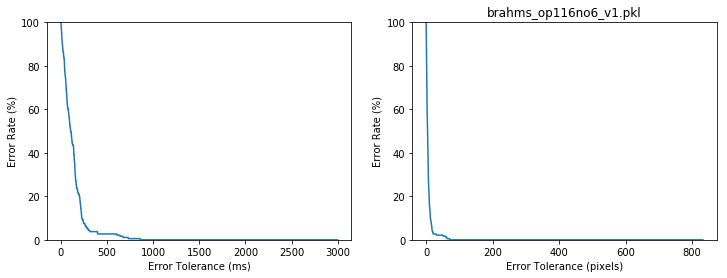

./hyp_align/brahms_op116no6_v2.pkl


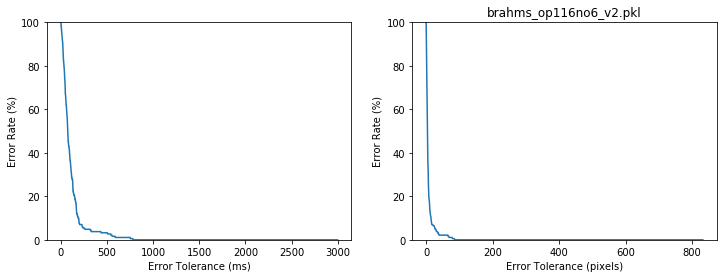

./hyp_align/brahms_op117no2_v1.pkl


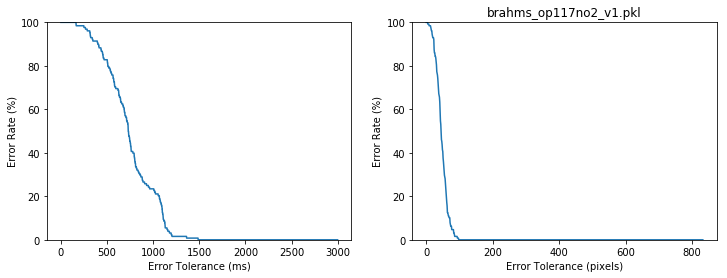

./hyp_align/brahms_op117no2_v2.pkl


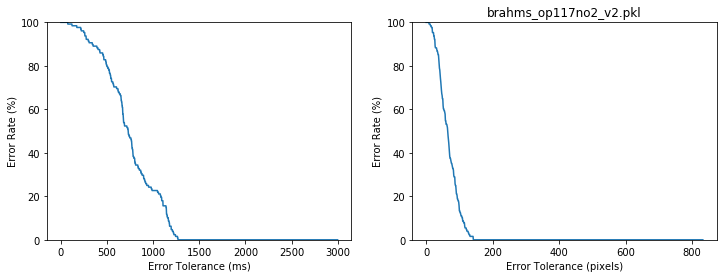

./hyp_align/brahms_op117no2_v3.pkl


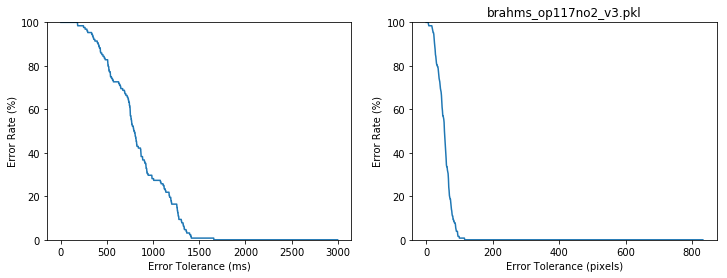

./hyp_align/brahms_op117no2_v4.pkl


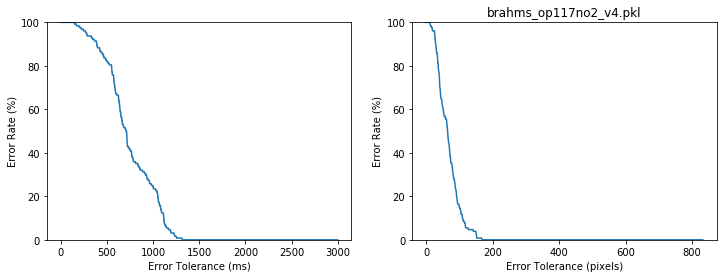

./hyp_align/chopin_op30no2_v1.pkl


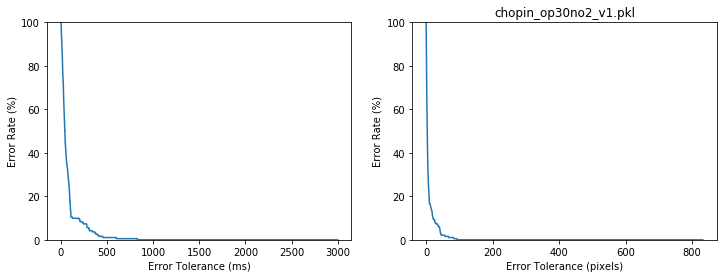

./hyp_align/chopin_op30no2_v2.pkl


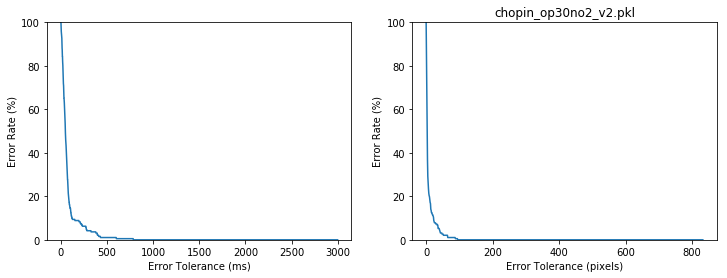

./hyp_align/chopin_op30no2_v3.pkl


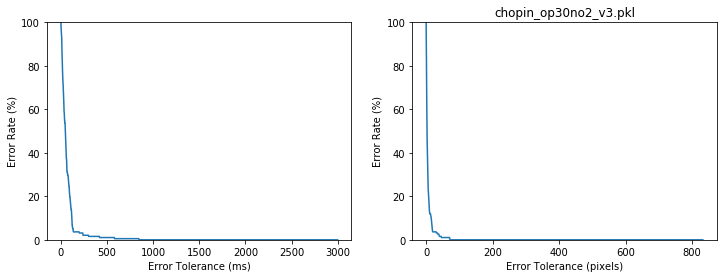

./hyp_align/chopin_op30no2_v4.pkl


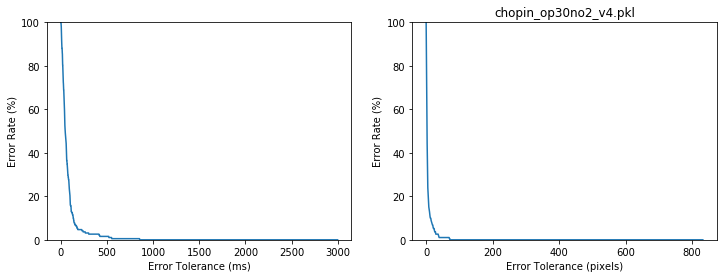

./hyp_align/chopin_op30no2_v5.pkl


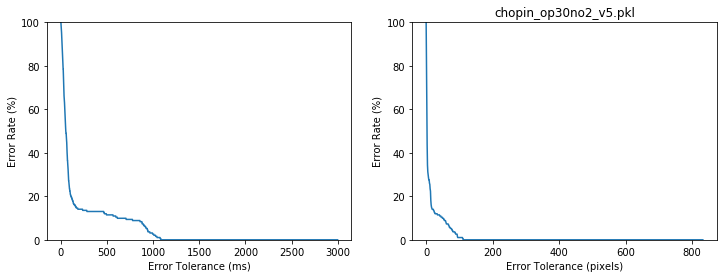

./hyp_align/chopin_op30no2_v6.pkl


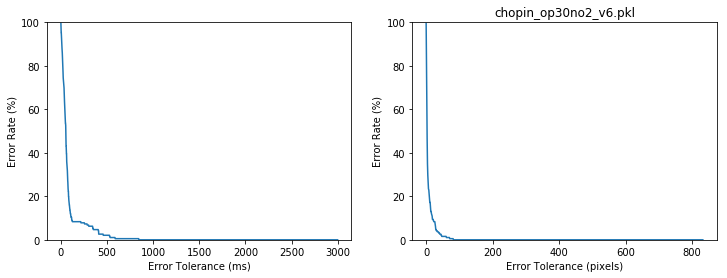

./hyp_align/chopin_op63no3_v1.pkl


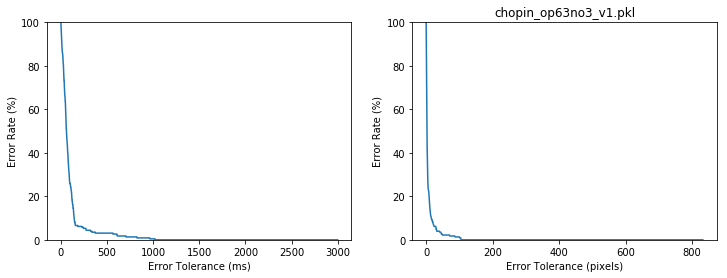

./hyp_align/chopin_op63no3_v2.pkl


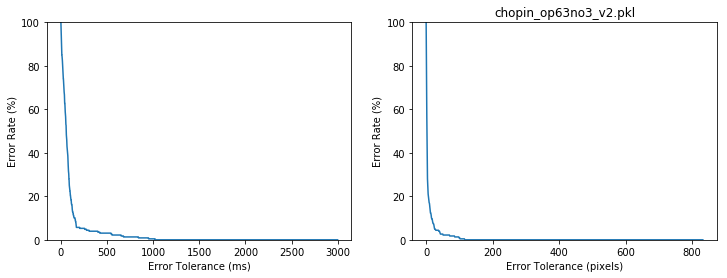

./hyp_align/chopin_op63no3_v3.pkl


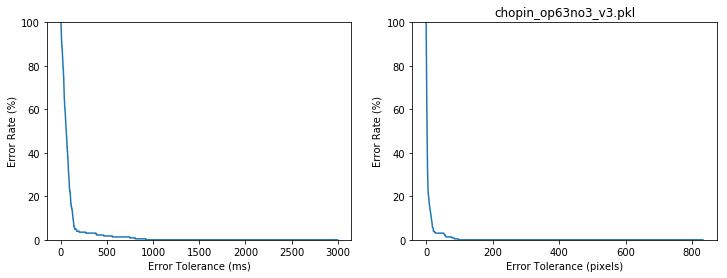

./hyp_align/chopin_op63no3_v4.pkl


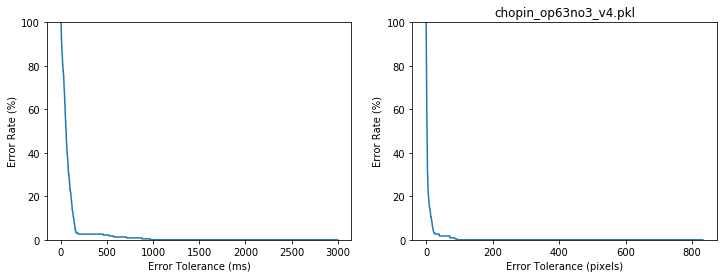

./hyp_align/chopin_op63no3_v5.pkl


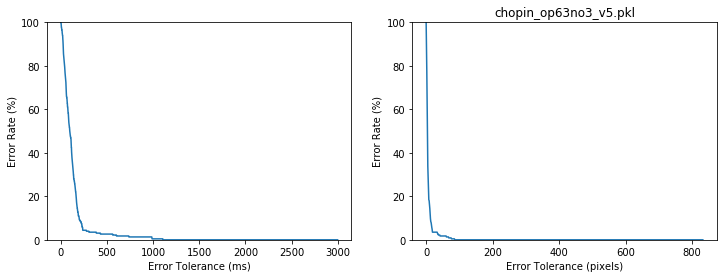

./hyp_align/chopin_op63no3_v6.pkl


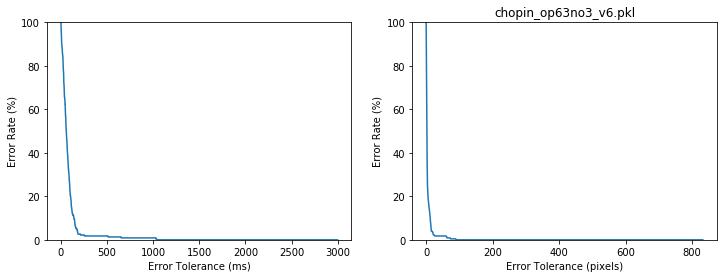

./hyp_align/chopin_op68no3_v1.pkl


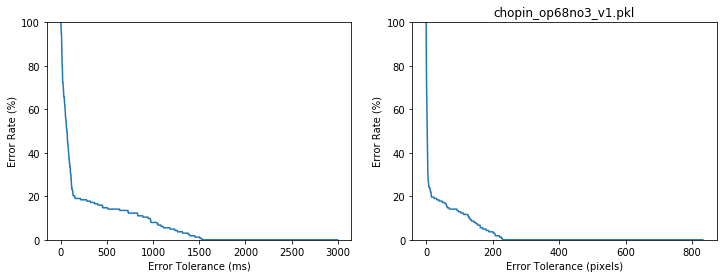

./hyp_align/chopin_op68no3_v2.pkl


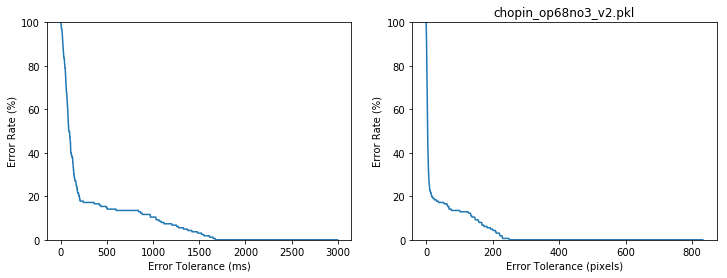

./hyp_align/chopin_op68no3_v3.pkl


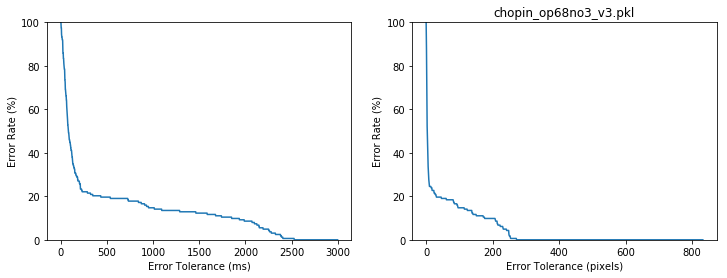

./hyp_align/chopin_op68no3_v4.pkl


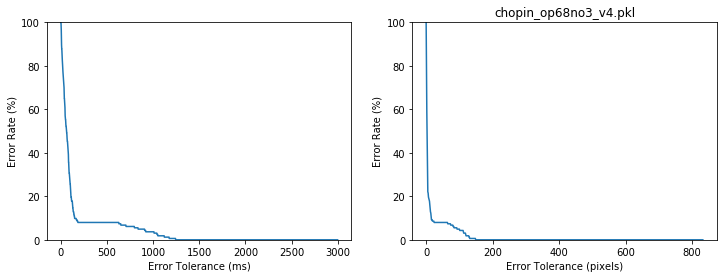

./hyp_align/chopin_op68no3_v5.pkl


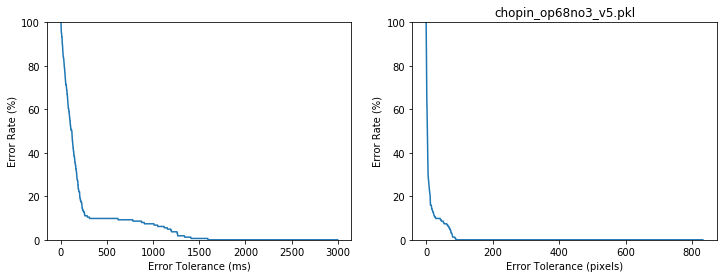

./hyp_align/chopin_op68no3_v6.pkl


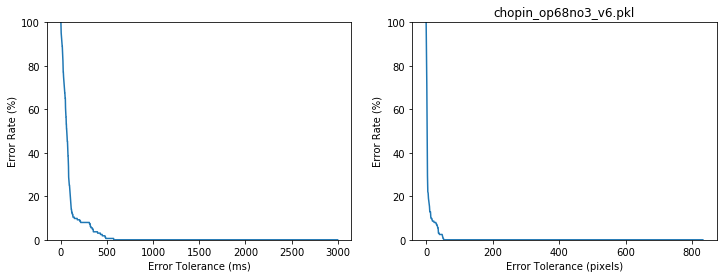

./hyp_align/clementi_op36no1mv3_v1.pkl


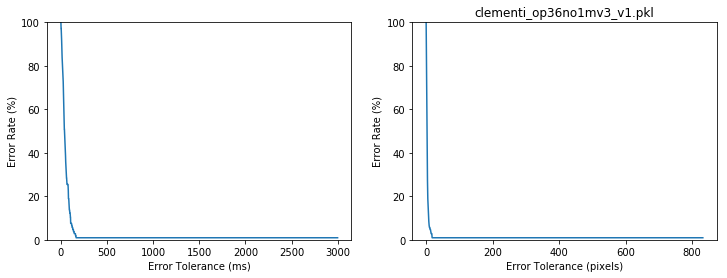

./hyp_align/clementi_op36no1mv3_v2.pkl


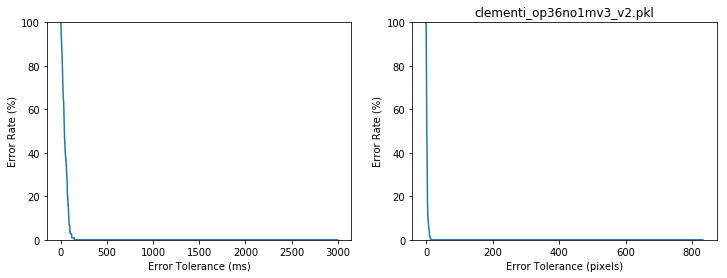

./hyp_align/clementi_op36no2mv3_v1.pkl


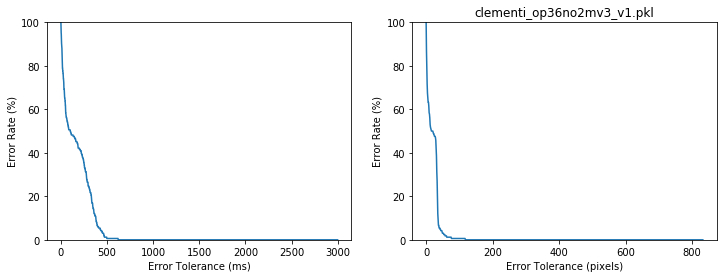

./hyp_align/clementi_op36no2mv3_v2.pkl


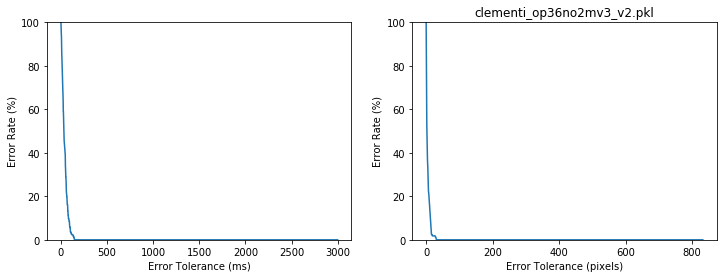

./hyp_align/clementi_op36no3mv3_v1.pkl


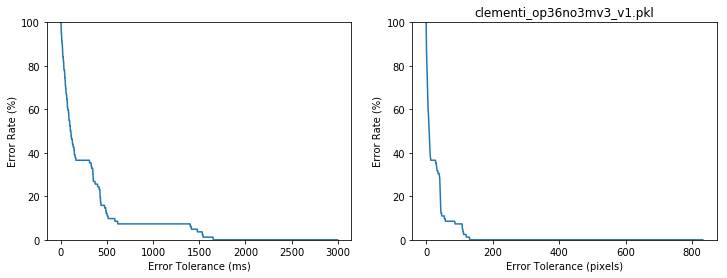

./hyp_align/clementi_op36no3mv3_v2.pkl


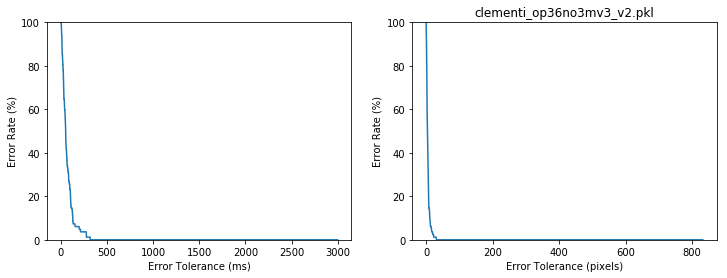

./hyp_align/debussy_childrencorner1_v1.pkl


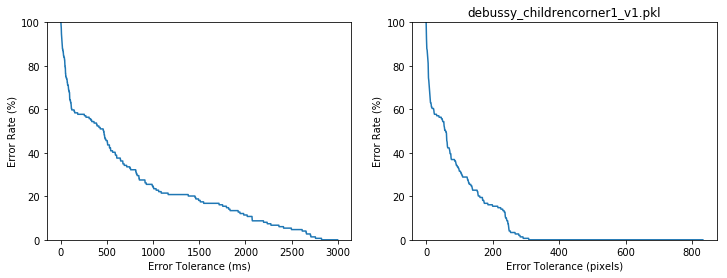

./hyp_align/debussy_childrencorner1_v2.pkl


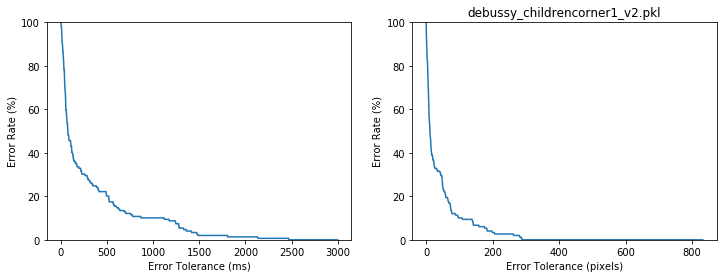

./hyp_align/debussy_childrencorner1_v3.pkl


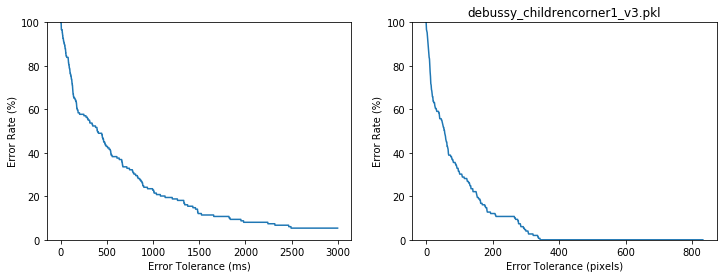

./hyp_align/debussy_childrencorner3_v1.pkl


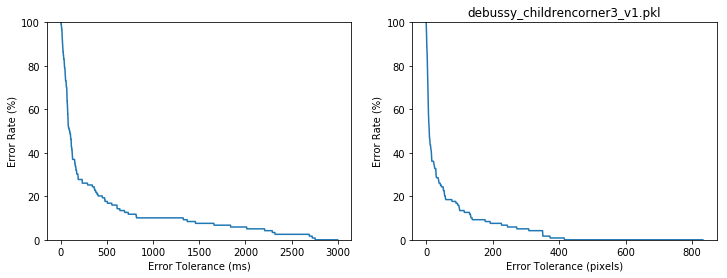

./hyp_align/debussy_childrencorner3_v2.pkl


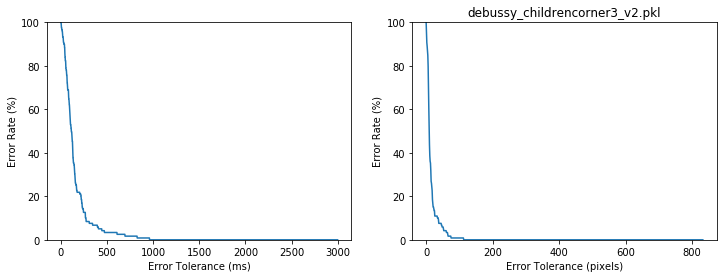

./hyp_align/debussy_childrencorner3_v3.pkl


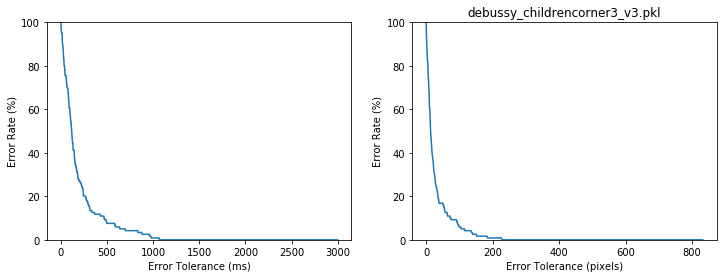

./hyp_align/debussy_childrencorner6_v1.pkl


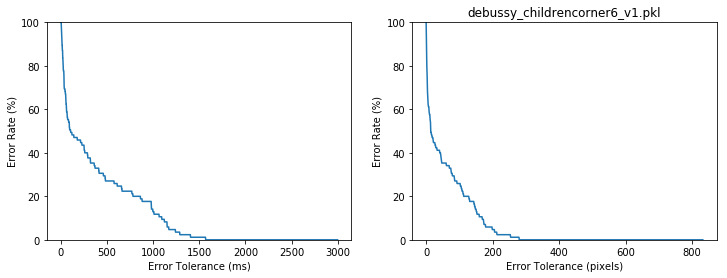

./hyp_align/debussy_childrencorner6_v2.pkl


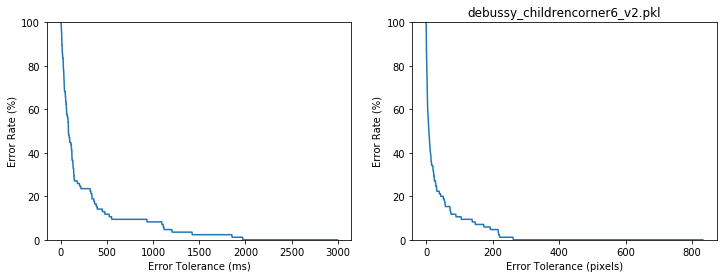

./hyp_align/debussy_childrencorner6_v3.pkl


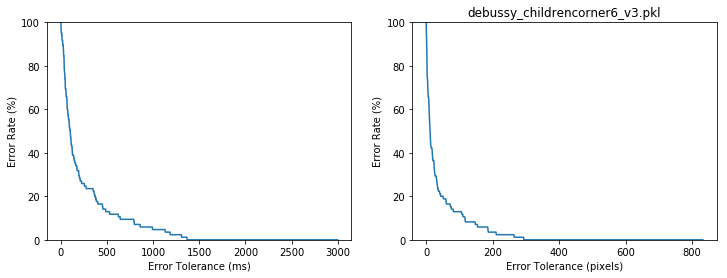

./hyp_align/mendelssohn_op19no2_v1.pkl


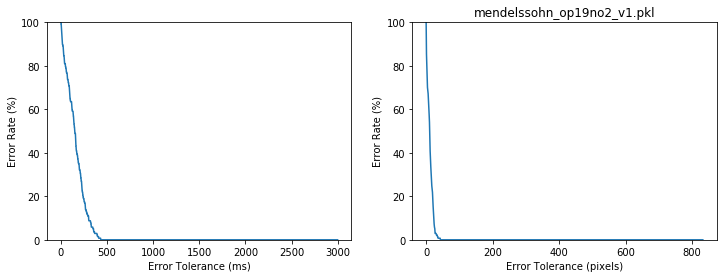

./hyp_align/mendelssohn_op19no2_v2.pkl


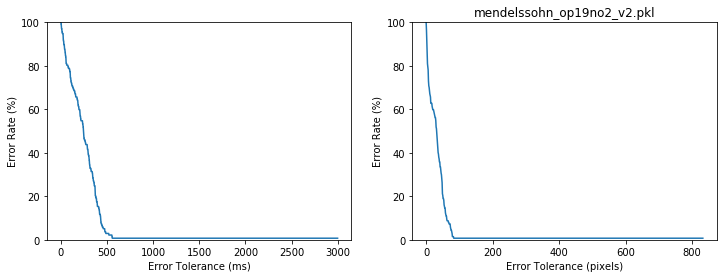

./hyp_align/mendelssohn_op19no2_v3.pkl


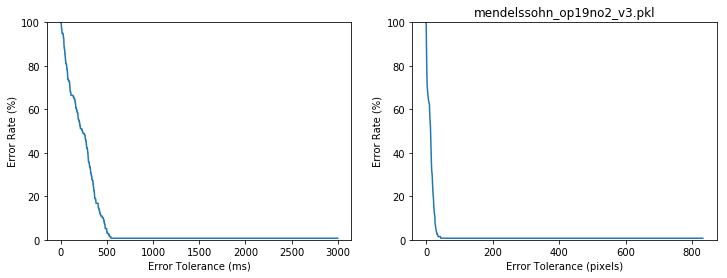

./hyp_align/mendelssohn_op19no2_v4.pkl


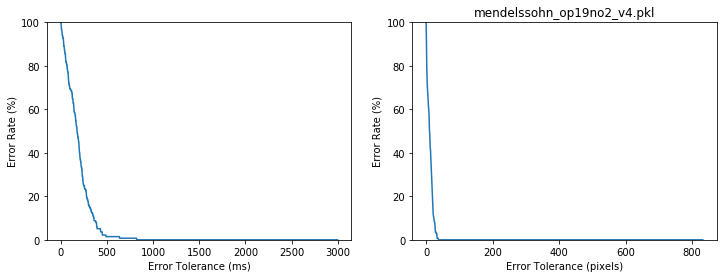

./hyp_align/mendelssohn_op19no2_v5.pkl


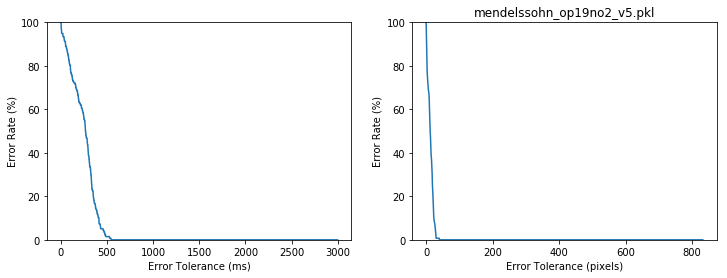

./hyp_align/mendelssohn_op62no3_v1.pkl


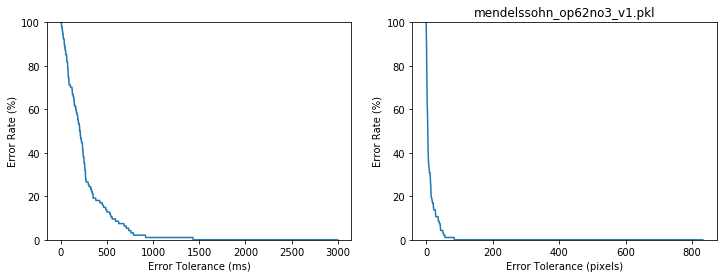

./hyp_align/mendelssohn_op62no3_v2.pkl


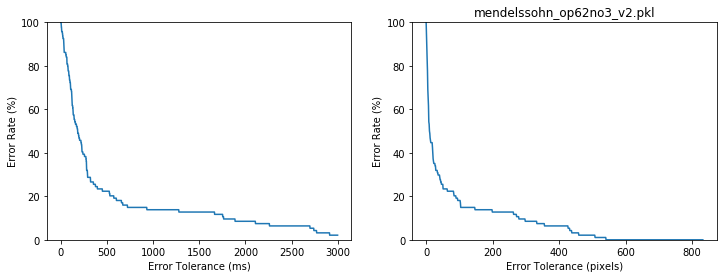

./hyp_align/mendelssohn_op62no3_v3.pkl


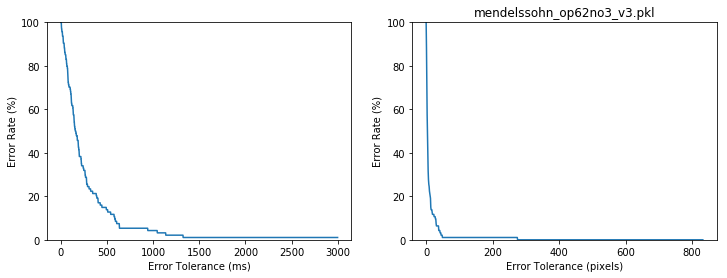

./hyp_align/mendelssohn_op62no5_v1.pkl


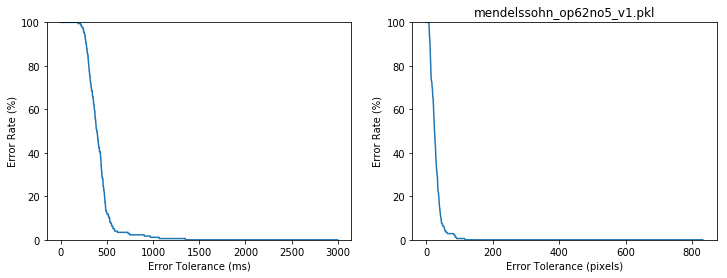

./hyp_align/mendelssohn_op62no5_v2.pkl


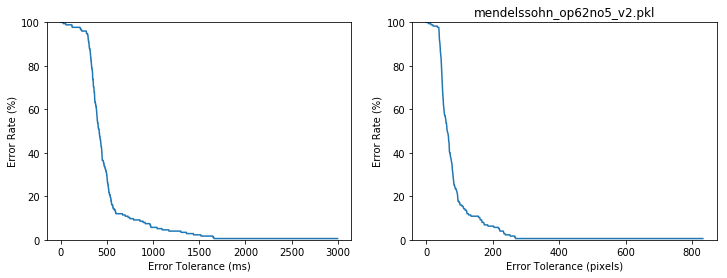

./hyp_align/mendelssohn_op62no5_v3.pkl


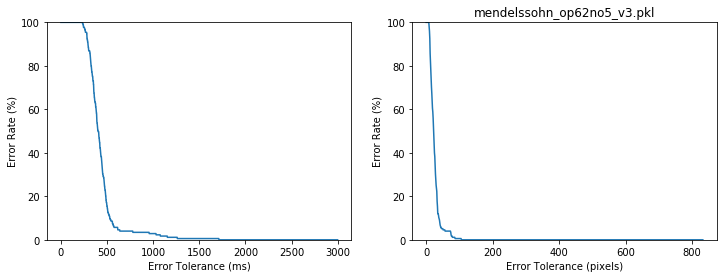

./hyp_align/mozart_kv311mv3_v1.pkl


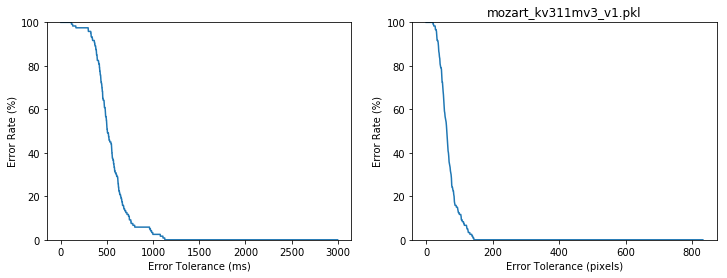

./hyp_align/mozart_kv311mv3_v2.pkl


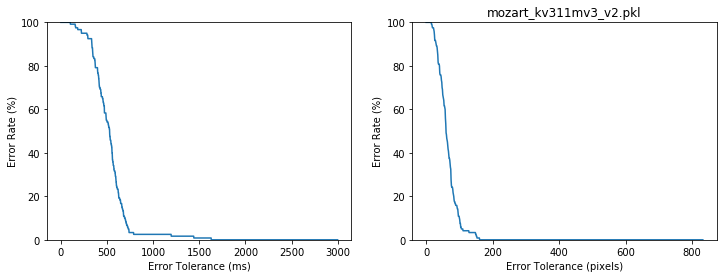

./hyp_align/mozart_kv311mv3_v3.pkl


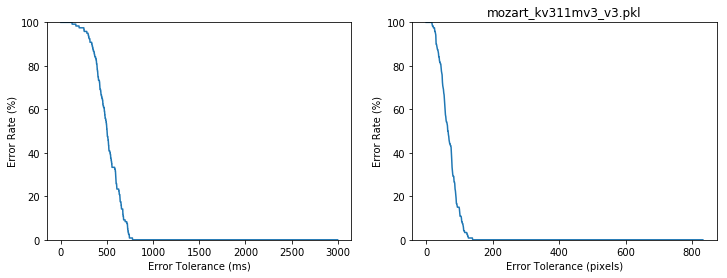

./hyp_align/mozart_kv333mv3_v1.pkl


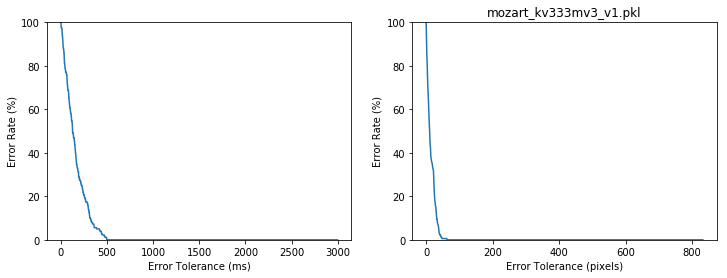

./hyp_align/mozart_kv333mv3_v2.pkl


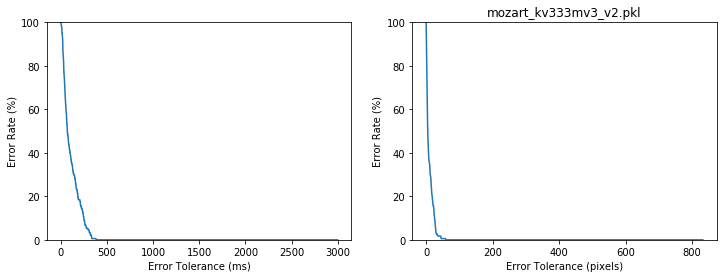

./hyp_align/mozart_kv333mv3_v3.pkl


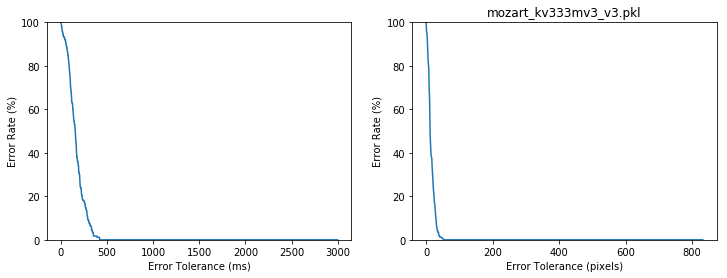

./hyp_align/mozart_kv333mv3_v4.pkl


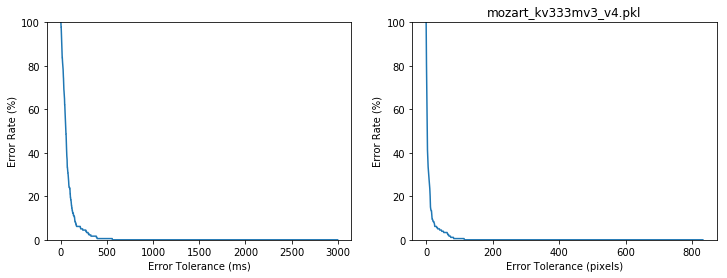

./hyp_align/schubert_op90no1_v1.pkl


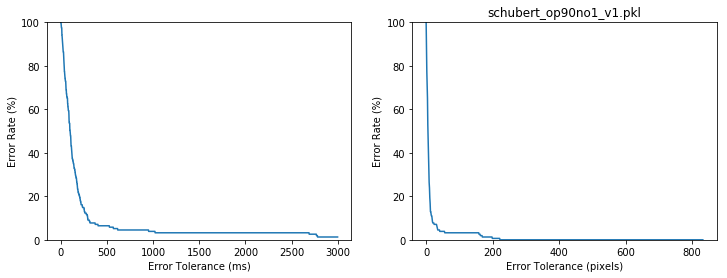

./hyp_align/schubert_op90no1_v2.pkl


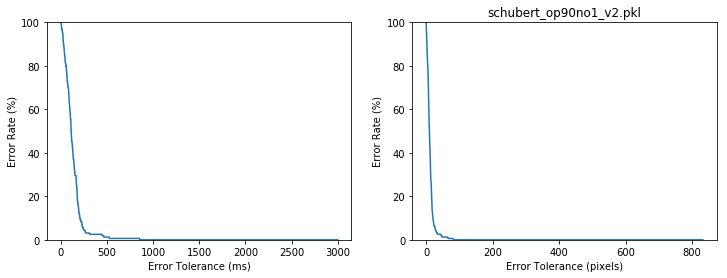

./hyp_align/schubert_op90no3_v1.pkl


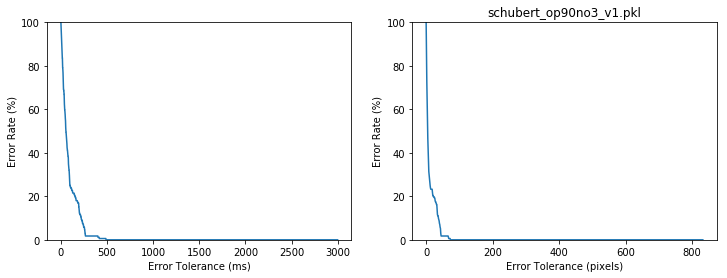

./hyp_align/schubert_op90no3_v2.pkl


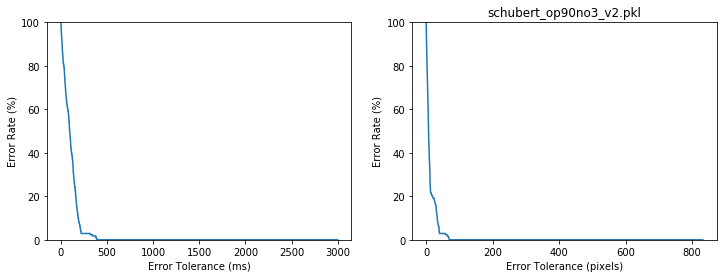

./hyp_align/schubert_op94no2_v1.pkl


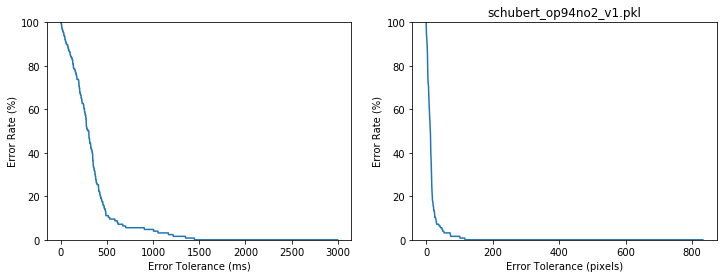

./hyp_align/schubert_op94no2_v2.pkl


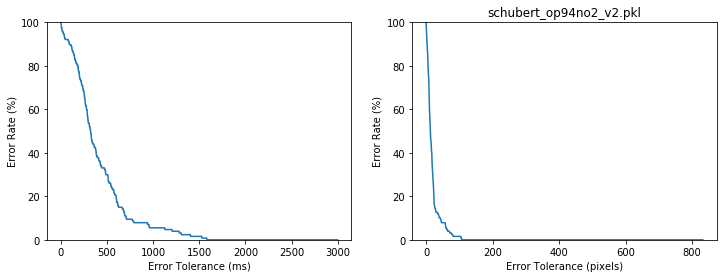

In [10]:
err_list = []
all_hyp = sorted(glob.glob(pkl_dir+'hyp_align/*'))
for hyp_file in all_hyp:
    err_list.append((plotErrorRateSingle(hyp_file, os.path.basename(hyp_file)), hyp_file))

### Measure error rate (all pairs)

In [11]:
def calcAllErrors(hyp_dir, predType, songlist):    
    
    hyp_files = []
    for piece in songlist:
        hyp_files = hyp_files + sorted(glob.glob('%s%s/%s*.pkl' % (pkl_dir,hyp_dir, piece)))
    #hyp_files = [f for f in hyp_files if 'pid9140-05' not in f] # omit files with structural differences
    time_errs = []
    pixel_errs = []
    debug = {}
    
    for hyp_file in hyp_files: # e.g. 'hyp_align/op68no3_v1--pid1263b-19-avgtapsd0.pkl'

        # calc errors
        errs_t, errs_l, midi_ref, sheet_ref = calcPredErrors(hyp_file, predType, True)
        time_errs.append(errs_t)
        pixel_errs.append(errs_l)
        
        # save debug info
        basename = os.path.splitext(os.path.basename(hyp_file))[0]
        scoreId = basename.split('--')[0]
        debug[scoreId] = sheet_ref
        debug[basename] = midi_ref
    
    with open('test_mzk.pkl', 'wb') as f:
        pickle.dump(debug, f)
        
    return time_errs, pixel_errs, hyp_files

In [12]:
songlist = ['brahms','chopin', 'clementi', 'debussy', 'mendelssohn', 'mozart', 'schubert','tchaikovsky']

In [13]:
time_errs_bs, pixel_errs_bs, hyp_files = calcAllErrors('hyp_align', 'wp', songlist) # bootleg synthesis
time_errs_b1, pixel_errs_b1, _ = calcAllErrors('hyp_align', 'globallinear', songlist) # baseline 1

./hyp_align/brahms_op116no6_v1.pkl
./hyp_align/brahms_op116no6_v2.pkl
./hyp_align/brahms_op117no2_v1.pkl
./hyp_align/brahms_op117no2_v2.pkl
./hyp_align/brahms_op117no2_v3.pkl
./hyp_align/brahms_op117no2_v4.pkl
./hyp_align/chopin_op30no2_v1.pkl
./hyp_align/chopin_op30no2_v2.pkl
./hyp_align/chopin_op30no2_v3.pkl
./hyp_align/chopin_op30no2_v4.pkl
./hyp_align/chopin_op30no2_v5.pkl
./hyp_align/chopin_op30no2_v6.pkl
./hyp_align/chopin_op63no3_v1.pkl
./hyp_align/chopin_op63no3_v2.pkl
./hyp_align/chopin_op63no3_v3.pkl
./hyp_align/chopin_op63no3_v4.pkl
./hyp_align/chopin_op63no3_v5.pkl
./hyp_align/chopin_op63no3_v6.pkl
./hyp_align/chopin_op68no3_v1.pkl
./hyp_align/chopin_op68no3_v2.pkl
./hyp_align/chopin_op68no3_v3.pkl
./hyp_align/chopin_op68no3_v4.pkl
./hyp_align/chopin_op68no3_v5.pkl
./hyp_align/chopin_op68no3_v6.pkl
./hyp_align/clementi_op36no1mv3_v1.pkl
./hyp_align/clementi_op36no1mv3_v2.pkl
./hyp_align/clementi_op36no2mv3_v1.pkl
./hyp_align/clementi_op36no2mv3_v2.pkl
./hyp_align/clementi_o

### Plot error curves

In [14]:
def getPrunedErrors(errs, hyp_files):
    errs_pruned = [l for i, l in enumerate(errs) if '_v4' not in hyp_files[i]] # omits poor quality sheet images 
    return errs_pruned

In [15]:
def calcAvgBeatLength_px():
    #with open('gt.pkl','rb') as f:
    with open('test_nonmzk.pkl','rb') as f:
        d = pickle.load(f)
    accum = 0
    cnt = 0
    for key in d:
        if '--' not in d:
            beats = d[key]
            diff = beats[1:] - beats[0:-1]
            accum += np.nansum(diff)
            cnt += len(diff) - np.sum(np.isnan(diff))
    print('Avg beat length: %.1f pixels' % (accum*1.0/cnt))

In [16]:
def calcAvgBeatLength_ms():
    annotfiles = glob.glob('annot_audio/op*/*.txt')
    accum = 0
    cnt = 0
    for annot_file in annotfiles:
        df = pd.read_csv(annot_file, header=None, sep='\t', comment='#')
        beats = df.loc[:,0].values
        diff = beats[1:] - beats[0:-1]
        accum += np.sum(diff)
        cnt += len(diff)
    print('Avg beat length: %.3f ms' % (accum * 1000.0 / cnt))

In [17]:
tols_px = range(51)
tols_ms = range(501)

# baseline 1
timeErrorRates_b1 = calcErrorStats(time_errs_b1, tols_ms)
pixelErrorRates_b1 = calcErrorStats(pixel_errs_b1, tols_px)

# bootleg synthesis
timeErrorRates_bs = calcErrorStats(time_errs_bs, tols_ms)
pixelErrorRates_bs = calcErrorStats(pixel_errs_bs, tols_px)

In [18]:
os.makedirs('results', exist_ok=True)
with open('results/errorData_real_bootleg.pkl','wb') as f:
    pickle.dump([pixel_errs_bs, pixel_errs_b1, time_errs_bs, time_errs_b1],f)

Frame error curves

In [19]:
calcAvgBeatLength_ms()

Avg beat length: 504.480 ms


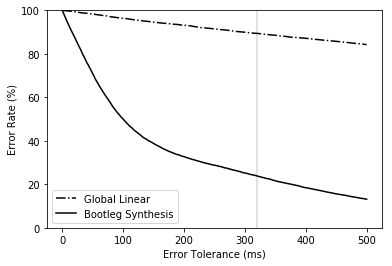

In [20]:
plt.axvline(x=320, color = '.85')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_b1), 'k-.', label='Global Linear')
#plt.plot(tols_ms, 100.0*np.array(timeErrorRates_b2), 'k--', label='Downbeat Oracle + Linear')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_bs), 'k-', label='Bootleg Synthesis')
#plt.plot(tols_ms, 100.0*np.array(timeErrorRates_bs_pruned), '.5', label='Bootleg Synthesis (pruned)')
plt.ylim((0,100))
plt.xlabel('Error Tolerance (ms)')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.savefig('figs/error_curves_bootleg.png', dpi=300, bbox_inches = 'tight')
plt.show()

Pixel error curves

In [21]:
calcAvgBeatLength_px()

Avg beat length: 32.4 pixels


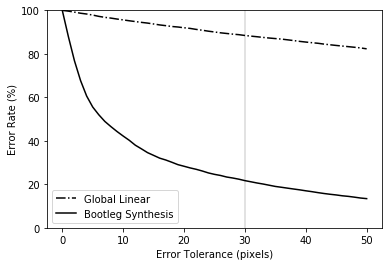

In [22]:
plt.axvline(x=30, color = '.85')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_b1), 'k-.', label='Global Linear')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_bs), 'k-', label='Bootleg Synthesis')
plt.ylim((0,100))
plt.xlabel('Error Tolerance (pixels)')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.savefig('error_curves_bootleg_px.png', dpi=300, bbox_inches = 'tight')
plt.show()